In [41]:
!huggingface-cli login

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ValueError: filedescriptor out of range in select()

In [1]:
!pip install -q -U git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets accelerate wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!mkdir /root/.kaggle/

In [10]:
!mkdir dataset

In [ ]:
%cd dataset
!unrar e /content/drive/MyDrive/Dataset/Datasets.rar

In [1]:
import datasets
import pandas as pd
from pathlib import Path
from PIL import Image
from transformers import AutoTokenizer

In [2]:
images_path = list(Path("/root/Datasets/Images").glob("*.jpg"))

In [3]:
labels = pd.read_csv("/root/Datasets/preprocess.csv")

In [4]:
images_path

[PosixPath('/root/Datasets/Images/1932161768_996eadac87.jpg'),
 PosixPath('/root/Datasets/Images/280932151_ae14a67be5.jpg'),
 PosixPath('/root/Datasets/Images/2714674623_8cd05ac114.jpg'),
 PosixPath('/root/Datasets/Images/2663794355_e726ec7e05.jpg'),
 PosixPath('/root/Datasets/Images/3596131692_91b8a05606.jpg'),
 PosixPath('/root/Datasets/Images/2552949275_b8cdc450cc.jpg'),
 PosixPath('/root/Datasets/Images/544257613_d9a1fea3f7.jpg'),
 PosixPath('/root/Datasets/Images/3503011427_a4ee547c77.jpg'),
 PosixPath('/root/Datasets/Images/1355450069_c0675b0706.jpg'),
 PosixPath('/root/Datasets/Images/3640348910_fcd627ec66.jpg'),
 PosixPath('/root/Datasets/Images/2157003092_eaeb977789.jpg'),
 PosixPath('/root/Datasets/Images/2737759676_4bc9be2daf.jpg'),
 PosixPath('/root/Datasets/Images/3174726084_c108de0a64.jpg'),
 PosixPath('/root/Datasets/Images/3707738261_777075e885.jpg'),
 PosixPath('/root/Datasets/Images/2844747252_64567cf14a.jpg'),
 PosixPath('/root/Datasets/Images/2841449931_84a05850ec.j

In [5]:
# labels['image'] = labels['image'].apply(lambda x: x.split("_")[0] + ".jpg")

In [6]:
import os

# names = os.listdir("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/")
# labels['is_in'] = labels['image'].apply(lambda x: True if x in names else False)

In [7]:
images_path[0].parent

PosixPath('/root/Datasets/Images')

In [8]:
images = [Image.open(str(images_path[0].parent / path)) for path in labels['image']]

In [9]:
dataset = datasets.Dataset.from_dict({"image": images, "text": labels['caption']})

In [10]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [58]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [59]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


In [13]:
dataset = dataset.train_test_split(test_size=0.1 , seed=42)

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 36409
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 4046
    })
})

In [15]:
# import torch
# import gc
# torch.cuda.empty_cache()
# gc.collect()

97

In [16]:
train_dataset = ImageCaptioningDataset(dataset['train'], processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, collate_fn=collate_fn)

test_dataset = ImageCaptioningDataset(dataset['test'], processor)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=32, collate_fn=collate_fn)

In [17]:
tokenizer = AutoTokenizer.from_pretrained("Xenova/llama-3-tokenizer")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
processor.tokenizer = tokenizer

In [19]:
processor.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [20]:
model.resize_token_embeddings(len(tokenizer))

Embedding(128257, 2560)

In [21]:
model.config.text_config.vocab_size = 128257
model.to('cuda')

PeftModel(
  (base_model): LoraModel(
    (model): Blip2ForConditionalGeneration(
      (vision_model): Blip2VisionModel(
        (embeddings): Blip2VisionEmbeddings(
          (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
        )
        (encoder): Blip2Encoder(
          (layers): ModuleList(
            (0-38): 39 x Blip2EncoderLayer(
              (self_attn): Blip2Attention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear8bitLt(in_features=1408, out_features=4224, bias=True)
                (projection): Linear8bitLt(in_features=1408, out_features=1408, bias=True)
              )
              (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
              (mlp): Blip2MLP(
                (activation_fn): GELUActivation()
                (fc1): Linear8bitLt(in_features=1408, out_features=6144, bias=True)
                (fc2): Linear8bitLt(in_features=6144, out_features=1408, bias=True)
      

In [47]:
# gradient checkpoint
# gradient accumulate
# mix precision
# change optimizer (memories effician)

import torch
from tqdm import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in range(10):
    training_loss = 0
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_dataloader)):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, torch.float16)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss

        training_loss += loss.item()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    print(training_loss / len(train_dataloader))
    # model.push_to_hub(".....", private=True)
    model.base_model.save_pretrained(f'model_epoch_{epoch}')
    # model.save_pretrained(f'model_epoch_{epoch}')


Epoch: 0


  0%|          | 0/1138 [00:00<?, ?it/s]

100%|██████████| 1138/1138 [20:28<00:00,  1.08s/it]


3.159823291959578
Epoch: 1


 36%|███▌      | 405/1138 [07:18<13:13,  1.08s/it]


KeyboardInterrupt: 

In [46]:
model.base_model.save_pretrained("test")

PeftModel(
  (base_model): LoraModel(
    (model): Blip2ForConditionalGeneration(
      (vision_model): Blip2VisionModel(
        (embeddings): Blip2VisionEmbeddings(
          (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
        )
        (encoder): Blip2Encoder(
          (layers): ModuleList(
            (0-38): 39 x Blip2EncoderLayer(
              (self_attn): Blip2Attention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear8bitLt(in_features=1408, out_features=4224, bias=True)
                (projection): Linear8bitLt(in_features=1408, out_features=1408, bias=True)
              )
              (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
              (mlp): Blip2MLP(
                (activation_fn): GELUActivation()
                (fc1): Linear8bitLt(in_features=1408, out_features=6144, bias=True)
                (fc2): Linear8bitLt(in_features=6144, out_features=1408, bias=True)
      

In [56]:
# model.save_pretrained("model_test_save")
model = model.base_model.from_pretrained('/root/p-mon/model_epoch_0')
# model.Q

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


RuntimeError: "normal_kernel_cpu" not implemented for 'Char'

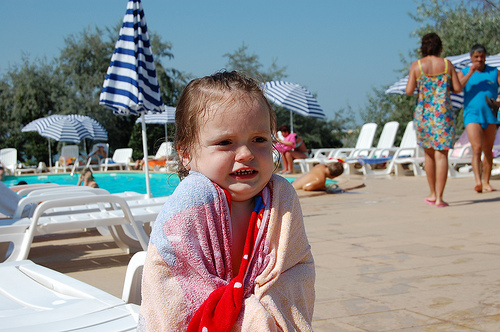

In [52]:
im = dataset['test'].select([0])['image'][0]
im

In [60]:
pixel_values = processor(im, return_tensors="pt").to(device, torch.float16).pixel_values
model.eval()

outputs = model.generate(pixel_values=pixel_values)

In [61]:
outputs

tensor([[    2,   102,   410,  1816,  8144,    11,    10, 21342, 50118]],
       device='cuda:0')

In [62]:
generated_caption = processor.batch_decode(outputs, skip_special_tokens=True)[0]
print(generated_caption)

a little girl wrapped in a towel

